In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

import time
from scipy.ndimage.interpolation import shift
import scipy.stats
import FinanceDataReader as fdr
import yfinance as yf
import seaborn as sns

In [2]:
def BSprice(PutCall, x, T, K, r, q, sigma):
    d1 =(1/(sigma*np.sqrt(T)))*(np.log(x/K) + (r - q + 0.5*sigma**2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(x/K) + (r - q - 0.5*sigma**2)*T)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    Nd1m = norm.cdf(-d1)
    Nd2m = norm.cdf(-d2)
    
    if PutCall == 'C':
        price1 = x*np.exp(-q*T)*Nd1 - K*np.exp(-r*T)*Nd2
        price2 = np.exp(-q*T)*Nd1
    elif PutCall =='P':
        price1 = K*np.exp(-r*T)*Nd2m - x*np.exp(-q*T)*Nd1m
        price2 = -np.exp(-q*T)*Nd1m
        
    return(price1,price2)           # returns array


# Hedging Cost 비교

In [5]:
def hedging_Call(s0,M,mu,K,r,sigma,T,q,PutCall,simulation_number):
    M_s=20/M
    M_s=np.int(M_s)
    dt=M/52    
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)



    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*s0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, sigma)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape

    initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade
    shares_purchased=Delta_change*100000
    shares_purchased=shares_purchased.round()  #정수만 purchase



    cost_purchased=shares_purchased*stock_price
    #trans_cost=np.where(cost_purchased<0,cost_purchased*0.0002,0) #transaction Cost
    trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/52)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>50,Final_cost-5000000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>50,Final_cost_tr-5000000,Final_cost_tr)

    Mean=np.mean(hedge_cost)
    Performance_MSR=np.std(hedge_cost)/240000


    Mean_tr=np.mean(hedge_cost_tr)
    Performance_MSR_tr=np.std(hedge_cost_tr)/240000

    return(Mean,Performance_MSR,Mean_tr,Performance_MSR_tr)



In [6]:
M=[5,4,2,1,0.5,0.25]
simulation_number=1000
s0=49
K=50
mu=0.13
r=0.05
sigma=0.2
q=0
PutCall='C'
T=20/52

In [7]:
for i in M:

    Mean,MSR,Mean_tr,MSR_tr=hedging_Call(s0,i,mu,K,r,sigma,T,q,PutCall,simulation_number)

    if i==5:
        m5=Mean
        m5_tr=Mean_tr
        std5=MSR
        std5_tr=MSR_tr


    if i==4:
        m4=Mean
        m4_tr=Mean_tr
        std4=MSR
        std4_tr=MSR_tr        

    if i==2:
        m2=Mean
        m2_tr=Mean_tr
        std2=MSR
        std2_tr=MSR_tr        


    if i==1:
        m1=Mean
        m1_tr=Mean_tr
        std1=MSR
        std1_tr=MSR_tr        

    if i==0.5:
        m05=Mean
        m05_tr=Mean_tr
        std05=MSR
        std05_tr=MSR_tr        

    if i==0.25:
        
        m025=Mean
        m025_tr=Mean_tr
        std025=MSR
        std025_tr=MSR_tr

        

### without transaction cost

In [8]:
df=pd.DataFrame([[m5/100000,m4/100000,m2/100000,m1/100000,m05/100000,m025/100000],[std5,std4,std2,std1,std05,std025]],columns=[5,4,2,1,0.5,0.25])
df.index=['Mean',"Performance MSR"]
df.columns.names=['Rebalance']
df

Rebalance,5.00,4.00,2.00,1.00,0.50,0.25
Mean,2.480611,2.410012,2.461489,2.474335,2.447943,2.459378
Performance MSR,0.413711,0.371036,0.255293,0.209472,0.137497,0.097204


### transaction cost included

In [9]:
df=pd.DataFrame([[m5_tr/100000,m4_tr/100000,m2_tr/100000,m1_tr/100000,m05_tr/100000,m025_tr/100000],[std5_tr,std4_tr,std2_tr,std1_tr,std05_tr,std025_tr]],columns=[5,4,2,1,0.5,0.25])
df.index=['Mean',"Performance MSR"]
df.columns.names=['Rebalance']
df

Rebalance,5.00,4.00,2.00,1.00,0.50,0.25
Mean,2.489924,2.419909,2.473190,2.489297,2.467112,2.484430
Performance MSR,0.413823,0.371201,0.255506,0.209902,0.137771,0.097553


In [10]:

M=1
M_s=20/M
M_s=np.int(M_s)
dt=M/52    
tt=np.repeat(T,M_s)
for i in range(M_s-1):
    tt[i+1]=tt[i]-dt
tt=np.append(tt,0)



# Generating random
generating_number=int(round(T*(1/dt)))+1

# generating stock path
z=np.random.randn(simulation_number,generating_number)
stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
stock_path_bm[:,0]=1
stock_price=stock_path_bm.cumprod(1)*s0

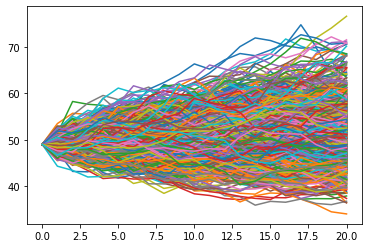

In [11]:
for i in range(1000):
    plt.plot(stock_price[i])

In [10]:
-----------절취선-----------------    #여기까지 기존 과제

SyntaxError: invalid syntax (Temp/ipykernel_18156/2620316181.py, line 1)

### 현재가 50,000원 strike = 55,000원  수량# 100,000 계약
### OPT 매도 포지션일때 내재 변동성 45%로 마진을 쌓아 놓고 Hedging PNL을 계산한다
### Int cost =4% daily calculation
### Transaction Cost= 0.1% at selling

In [47]:
PutCall='C'
x=50
T=26/52
K=55
r=0.04
q=0
sigma=0.46


c_price=BSprice(PutCall, x, T, K, r, q, sigma)[0]
c_price*100000   #Margin

493429.7619008678

In [41]:
simulation_number=1000
s0=50
K=55
mu=0.13
r=0.04
sigma=0.4
q=0
PutCall='C'
T=26/52

In [54]:
def hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number):
    M=1
    M_s=26/M
    M_s=np.int(M_s)
    dt=M/52    
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)



    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*s0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, sigma)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape

    initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade
    shares_purchased=Delta_change*100000
    shares_purchased=shares_purchased.round()  #정수만 purchase



    cost_purchased=shares_purchased*stock_price
    trans_cost=np.where(cost_purchased<0,cost_purchased*0.001,0) #transaction Cost # 매도시에만 10BP
    #trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/52)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>K,Final_cost-K*100000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>K,Final_cost_tr-K*100000,Final_cost_tr)

    ATM_C=np.where((stock_price[:,-1]<1.01*K)&(stock_price[:,-1]>0.99*K),hedge_cost,0)    #ATM 으로 끝났을때
    ITM_C=np.where(stock_price[:,-1]>K,hedge_cost,0)    #ITM 으로 끝났을때 
    OTM_C=np.where(stock_price[:,-1]<K,hedge_cost,0)    #OTM 으로 끝났을때

    ATM_Case=ATM_C[ATM_C!=0]
    ITM_Case=ITM_C[ITM_C!=0]
    OTM_Case=OTM_C[OTM_C!=0]


    hedging_PNL=(c_price*100000-hedge_cost)

    Mean=np.mean(hedge_cost)    # transcation cost 포함하지 않은 hedging cost
    Performance_MSR=np.std(hedge_cost)/240000


    Mean_tr=np.mean(hedge_cost_tr)   #transaction cost 포함함 hedging cost
    Performance_MSR_tr=np.std(hedge_cost_tr)/240000
    Mean_hedging_PNL=np.mean(hedging_PNL)


    return(Mean,Performance_MSR,Mean_tr,Performance_MSR_tr,np.mean(ITM_Case),np.mean(OTM_Case),np.mean(ATM_Case),Mean_hedging_PNL)




In [55]:
s0=50
K=55
mu=0.13
r=0.04
sigma=0.4
q=0
PutCall='C'
T=26/52
simulation_number=1000


## transaction cost 비교

In [56]:
Mean_without_transcost=np.zeros(1000)
Mean_with_transcost=np.zeros(1000)
for i in tqdm(range(1000)):
    
    Mean_without_transcost[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[0]
    Mean_with_transcost[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[2]


100%|██████████| 1000/1000 [00:22<00:00, 44.53it/s]


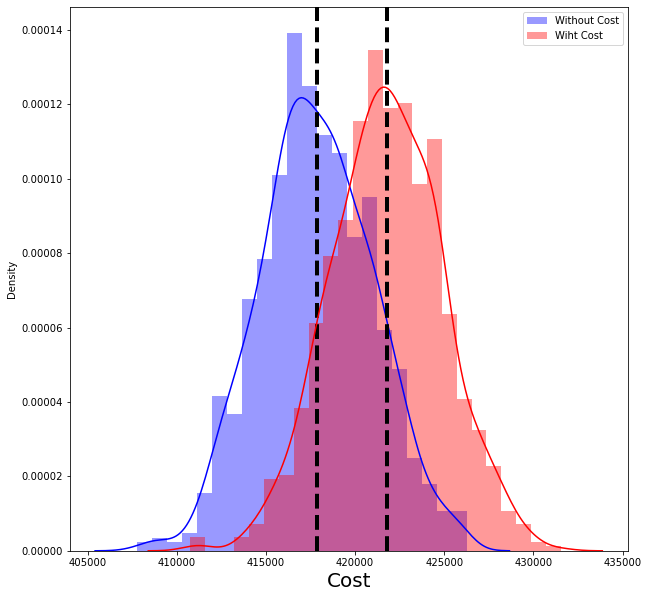

In [57]:
plt.figure(figsize=(10,10))
sns.distplot(Mean_without_transcost,color='blue',label='Without Cost')
plt.axvline(x=Mean_without_transcost.mean(),color='black',ls='--',lw=4)

sns.distplot(Mean_with_transcost,color='red',label="Wiht Cost")
plt.axvline(x=Mean_with_transcost.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

## Hedging PNL

In [58]:
a=np.zeros(1000)
for i in tqdm(range(1000)):
    a[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[7]

100%|██████████| 1000/1000 [00:12<00:00, 79.65it/s]


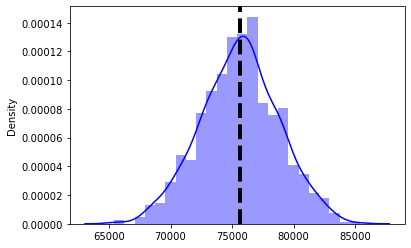

In [59]:
sns.distplot(a,color='blue')
plt.axvline(x=a.mean(),color='black',ls='--',lw=4)

### ITM ATM OTM case

In [60]:
ITM_=np.zeros(1000)
ATM_=np.zeros(1000)
OTM_=np.zeros(1000)
for i in tqdm(range(1000)):
    
    ITM_[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[4]
    OTM_[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[5]
    ATM_[i]=hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number)[6]

100%|██████████| 1000/1000 [00:42<00:00, 23.66it/s]


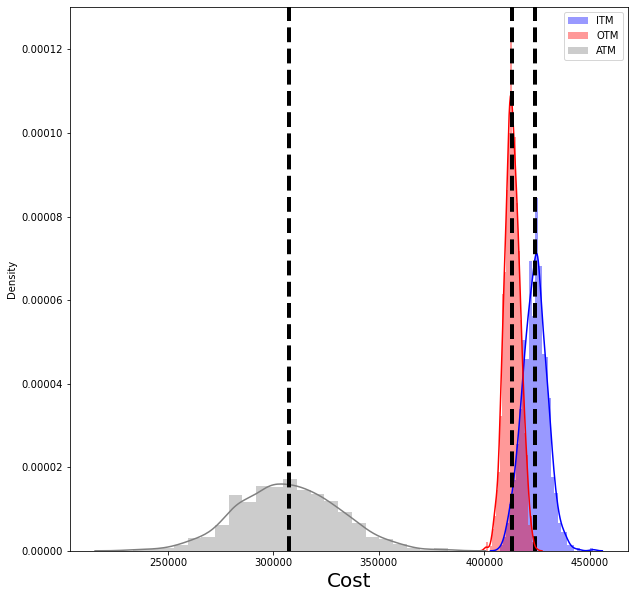

In [61]:
plt.figure(figsize=(10,10))
sns.distplot(ITM_,color='blue',label='ITM')
plt.axvline(x=ITM_.mean(),color='black',ls='--',lw=4)

sns.distplot(OTM_,color='red',label="OTM")
plt.axvline(x=OTM_.mean(),color='black',ls='--',lw=4)

sns.distplot(ATM_,color='gray',label="ATM")
plt.axvline(x=ATM_.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

## Delta Trigger

In [ ]:
c_price=BSprice(PutCall="C", x=50, T=26/52, K=55, r=0.04, q=0, sigma=0.46)[0]
c_price*100000   #Margin
c_price_origin=BSprice(PutCall="C", x=50, T=26/52, K=55, r=0.04, q=0, sigma=0.40)[0]
c_price_origin   #Margin

4.092017438543866

In [ ]:
s0=49
K=50
mu=0.13
r=0.05
sigma=0.2
q=0
PutCall='C'
T=26/52
simulation_number=10000


In [ ]:
def delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,trigger):
    M=1
    M_s=26/M
    M_s=np.int(M_s)
    dt=M/52    
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)



    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*s0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, sigma)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape
    Delta_diff_trigger=np.where(Delta_diff>Delta[:,:-1]*trigger,Delta_diff,0)

    initial_array=np.repeat(Delta[0][0],Delta_diff_trigger.shape[0]).reshape(Delta_diff_trigger.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff_trigger],axis=1)

    # initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    # Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade

    shares_purchased=Delta_change*100000
    np.where(shares_purchased)
    shares_purchased=shares_purchased.round()  #정수만 purchase



    cost_purchased=shares_purchased*stock_price
    trans_cost=np.where(cost_purchased<0,cost_purchased*0.001,0) #transaction Cost # 매도시에만 10BP
    #trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/52)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>K,Final_cost-K*100000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>K,Final_cost_tr-K*100000,Final_cost_tr)

    # ATM_C=np.where((stock_price[:,-1]<(K+1))&(stock_price[:,-1]>(K-1)),hedge_cost,0)   #ATM 으로 끝났을때
    # ITM_C=np.where(stock_price[:,-1]>K,hedge_cost,0)    #ITM 으로 끝났을때 
    # OTM_C=np.where(stock_price[:,-1]<K,hedge_cost,0)    #OTM 으로 끝났을때

    # ATM_Case=ATM_C[ATM_C!=0]
    # ITM_Case=ITM_C[ITM_C!=0]
    # OTM_Case=OTM_C[OTM_C!=0]


    hedging_PNL=(c_price*100000-hedge_cost)

    Mean=np.mean(hedge_cost)    # transcation cost 포함하지 않은 hedging cost
    Performance_MSR=np.std(hedge_cost)/(c_price_origin*100000)


    Mean_tr=np.mean(hedge_cost_tr)   #transaction cost 포함함 hedging cost
    Performance_MSR_tr=np.std(hedge_cost_tr)/(c_price_origin*100000)
    Mean_hedging_PNL=np.mean(hedging_PNL)

    return(Mean,Performance_MSR)
    #,Mean_tr,Performance_MSR_tr#,np.mean(ITM_Case),np.mean(OTM_Case),np.mean(ATM_Case),Mean_hedging_PNL




In [196]:
def hedging_C(s0,mu,K,r,sigma,T,q,PutCall,simulation_number):
    M=1
    M_s=26/M
    M_s=np.int(M_s)
    dt=M/52    
    tt=np.repeat(T,M_s)
    for i in range(M_s-1):
        tt[i+1]=tt[i]-dt
    tt=np.append(tt,0)



    # Generating random
    generating_number=int(round(T*(1/dt)))+1

    # generating stock path
    z=np.random.randn(simulation_number,generating_number)
    stock_path_bm=np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*z)
    stock_path_bm[:,0]=1
    stock_price=stock_path_bm.cumprod(1)*s0

    # Calculating Delta
    Delta=BSprice(PutCall,stock_price, tt, K, r, q, sigma)[1]
    Delta_diff=Delta[:,1:]-Delta[:,:-1]
    Delta_diff.shape

    initial_array=np.repeat(Delta[0][0],Delta_diff.shape[0]).reshape(Delta_diff.shape[0],1)
    Delta_change=np.concatenate([initial_array,Delta_diff],axis=1)

    # Delta 변화에따른 stock trade
    shares_purchased=Delta_change*100000
    shares_purchased=shares_purchased.round()  #정수만 purchase



    cost_purchased=shares_purchased*stock_price
    trans_cost=np.where(cost_purchased<0,cost_purchased*0.001,0) #transaction Cost # 매도시에만 10BP
    #trans_cost=cost_purchased*0.00015
    trans_cost=abs(trans_cost)
    transaction=np.cumsum(trans_cost,axis=1)
    cum_cost=np.cumsum(cost_purchased,axis=1)

    # Interest Cost 계산
    for i in range(1,cum_cost.shape[1]):

        cum_cost[:,i]=cum_cost[:,i-1]*np.exp(r*M/52)+cost_purchased[:,i]


    # Final cost 계산
    Final_cost=cum_cost[:,-1]
    hedge_cost=np.where(stock_price[:,-1]>K,Final_cost-K*100000,Final_cost)

    Final_cost_tr=cum_cost[:,-1]+transaction[:,-1]
    hedge_cost_tr=np.where(stock_price[:,-1]>K,Final_cost_tr-K*100000,Final_cost_tr)

    ATM_C=np.where((stock_price[:,-1]<1.01*K)&(stock_price[:,-1]>0.99*K),hedge_cost,0)    #ATM 으로 끝났을때
    ITM_C=np.where(stock_price[:,-1]>K,hedge_cost,0)    #ITM 으로 끝났을때 
    OTM_C=np.where(stock_price[:,-1]<K,hedge_cost,0)    #OTM 으로 끝났을때

    ATM_Case=ATM_C[ATM_C!=0]
    ITM_Case=ITM_C[ITM_C!=0]
    OTM_Case=OTM_C[OTM_C!=0]


    hedging_PNL=(c_price*100000-hedge_cost)

    Mean=np.mean(hedge_cost)    # transcation cost 포함하지 않은 hedging cost
    Performance_MSR=np.std(hedge_cost)/240000


    Mean_tr=np.mean(hedge_cost_tr)   #transaction cost 포함함 hedging cost
    Performance_MSR_tr=np.std(hedge_cost_tr)/240000
    Mean_hedging_PNL=np.mean(hedging_PNL)


    return(Mean,Performance_MSR,Mean_tr,Performance_MSR_tr,np.mean(ITM_Case),np.mean(OTM_Case),np.mean(ATM_Case),Mean_hedging_PNL)




In [197]:
def delta_trigger_sim(trigger):
    mean_trig=[]
    std_trig=[]
    s0=50
    K=55
    mu=0.13
    r=0.04
    sigma=0.4
    q=0
    T=26/52
    simulation_number=1000
    for g in trigger:
        mean_trig.append(delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,g)[0])
        std_trig.append(delta_trigger_result(s0,K,mu,r,sigma,q,T,simulation_number,g)[1])
        
    return(mean_trig,std_trig)
    

In [198]:
trigger=np.linspace(0.05,0.4,50)
trigger=list(trigger)

### Trigger를 크게줄수록 hedging cost 줄어든다

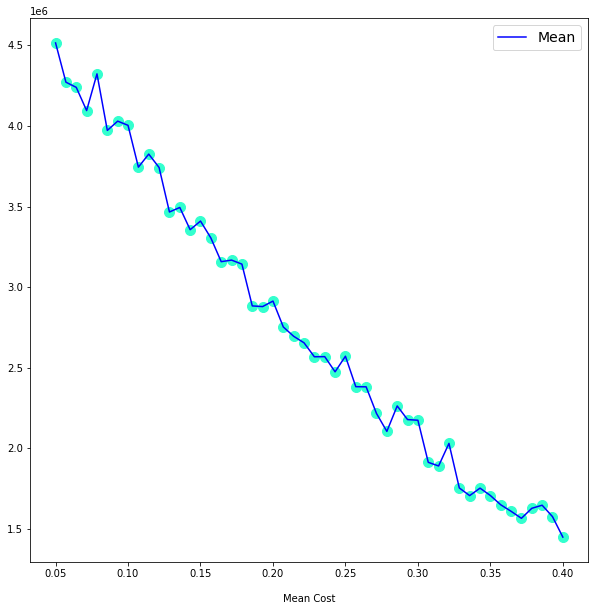

In [209]:
plt.figure(figsize=(10,10))

y=delta_trigger_sim(trigger)[0]
x=trigger
plt.scatter(x,y,s=100,c='#33FFCE')
plt.plot(x,y,linestyle='solid',color='blue',label="Mean")
plt.xlabel("Trigger",labelpad=15)
plt.xlabel("Mean Cost",labelpad=15)
plt.legend(fontsize=14)
plt.show()

### Trigger 크게줄수록 STD 증가

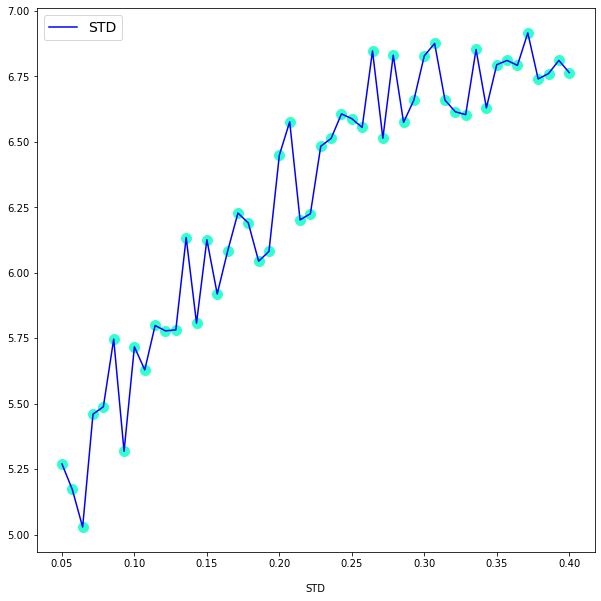

In [210]:
plt.figure(figsize=(10,10))

y=delta_trigger_sim(trigger)[1]
x=trigger
plt.scatter(x,y,s=100,c='#33FFCE')
plt.plot(x,y,linestyle='solid',color='blue',label="STD")
plt.xlabel("Trigger",labelpad=15)
plt.xlabel("STD",labelpad=15)
plt.legend(fontsize=14)
plt.show()